## Import

In [ ]:
import pickle
import matplotlib.pyplot as plt
import warnings

from config import CONFIG
from easydict import EasyDict

from env.env_f import *
from state.state import *
from agent.PPOAgent_ms import *
from models.CTTS import *
from trainer.nonEpisodic import *
from trainer.Episodic import *
from datahandler.scaler import *
from utils.setDevice import *
from utils.timestepRelated import *
from visualization.methods import *

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Load

In [ ]:
with open('../data/processed/kospi200_ffill_clean_version.pkl', 'rb') as f:
    df = pickle.load(f)

df.head(5)

## Set State info • scaler

In [ ]:
target_values = ['open', 'high', 'low', 'close', 
                'vol','return_5', 'return_10', 'volume_change', 'ema_5', 
                'ema_20', 'ema_cross', 'cci', 'sar', '%K', 
                # '%D', 'roc', 'rsi', 'obv', 'ad_line', 
                'bb_upper', 'bb_lower', 'bb_width', 'atr', 'gap_size']

scaler = RobustScaler()

## Set Env info 

In [ ]:
train_valid_timestep = split_date_ranges_by_group(df.index[:50000])
train_valid_timestep 

In [ ]:
# 
execution_strength = CONFIG.MAX_CONTRACT 
action_space = list(range(-execution_strength, execution_strength+1))
n_actions = len(action_space)
device = get_device() # torch.device("cpu")  

CONFIG.INPUT_DIM = len(target_values)
CONFIG.REWARD_FTN = risk_adjusted_pnl_reward
CONFIG.DONE_FTN = is_day_changed
CONFIG.TRAIN_VALID_TIMESTEP = train_valid_timestep
CONFIG.SCALER = scaler

In [ ]:
state =  State(target_values)

model = MultiStatePV(
    input_dim=CONFIG.INPUT_DIM,
    agent_input_dim=CONFIG.AGENT_INPUT_DIM,
    embed_dim=CONFIG.EMBED_DIM,
    kernel_size=CONFIG.KERNEL_SIZE,
    stride=CONFIG.STRIDE,
    action_size=CONFIG.N_ACTIONS,
    device=device,
    agent_hidden_dim=CONFIG.AGENT_HIDDEN_DIM,
    agent_out_dim=CONFIG.AGENT_OUT_DIM,
    fusion_hidden_dim=CONFIG.FUSION_HIDDEN_DIM,
    num_layers=CONFIG.NUM_LAYERS,
    num_heads=CONFIG.NUM_HEADS,
    d_ff=CONFIG.D_FF,
    dropout=CONFIG.DROPOUT
)

agent = PPOAgent(
    action_space=CONFIG.ACTION_SPACE,
    n_actions=CONFIG.N_ACTIONS,
    model=model,
    value_coeff=CONFIG.VALUE_COEFF,
    entropy_coeff=CONFIG.ENTROPY_COEFF,
    clip_eps=CONFIG.CLIP_EPS,
    gamma=CONFIG.GAMMA,
    lr=CONFIG.LR,
    batch_size=CONFIG.BATCH_SIZE,
    epoch=CONFIG.EPOCH,
    device=device
)

✅ 설정 저장 완료: /Users/ijimin/Documents/GitHub/YOLO-Futures/logs/test2/setting.txt
== [0] interval training ===========================
Robust Scaling Completed.
Robust Scaling Completed.
>>>> Train : ('2010-02-16', '2010-03-22')
[0|Train] Ep 001 | info:  | Maintained for: 100 | Reward: -179 | Loss:  3.026 | Pos(short/hold/long): 41% / 10% / 49% | Strength: 4.90 |
[0|Train] Ep 002 | info:  | Maintained for: 200 | Reward: -127 | Loss:  2.567 | Pos(short/hold/long): 44% / 11% / 45% | Strength: 4.15 |
[0|Train] Ep 003 | info:  | Maintained for: 300 | Reward: -202 | Loss:  4.004 | Pos(short/hold/long): 46% / 5% / 49% | Strength: 5.11 |
[0|Train] Ep 005 | info:  | Maintained for: 416 | Reward: -218 | Loss:  3.167 | Pos(short/hold/long): 46% / 7% / 47% | Strength: 4.86 |
[0|Train] Ep 006 | info:  | Maintained for: 516 | Reward: -155 | Loss:  2.836 | Pos(short/hold/long): 48% / 4% / 48% | Strength: 5.13 |
[0|Train] Ep 007 | info: bankrupt | Maintained for: 596 | Reward:  -99 | Loss:  1.669 | Pos(

/Users/ijimin/Documents/GitHub/YOLO-Futures/code/trainer/nonEpisodic.py:301: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(figsize=(12,6))


✅ 시각화 저장 완료: /Users/ijimin/Documents/GitHub/YOLO-Futures/logs/test2/visualization/I21T
>>>>> reset the env : bankrupt occured. Go Back To Start.
[0|Train] Ep 158 | info:  | Maintained for: 100 | Reward: -130 | Loss:  2.449 | Pos(short/hold/long): 50% / 0% / 50% | Strength: 4.44 |
[0|Train] Ep 159 | info:  | Maintained for: 200 | Reward: -173 | Loss:  3.047 | Pos(short/hold/long): 45% / 8% / 47% | Strength: 4.82 |
[0|Train] Ep 160 | info:  | Maintained for: 300 | Reward: -147 | Loss:  2.082 | Pos(short/hold/long): 52% / 2% / 46% | Strength: 5.00 |
[0|Train] Ep 162 | info:  | Maintained for: 416 | Reward: -221 | Loss:  2.358 | Pos(short/hold/long): 50% / 3% / 47% | Strength: 5.18 |
[0|Train] Ep 163 | info:  | Maintained for: 516 | Reward: -123 | Loss:  1.933 | Pos(short/hold/long): 49% / 9% / 42% | Strength: 4.20 |
[0|Train] Ep 164 | info:  | Maintained for: 616 | Reward: -156 | Loss:  2.599 | Pos(short/hold/long): 51% / 2% / 47% | Strength: 4.65 |
=== Improved Futures Trading Environmen

KeyboardInterrupt: 

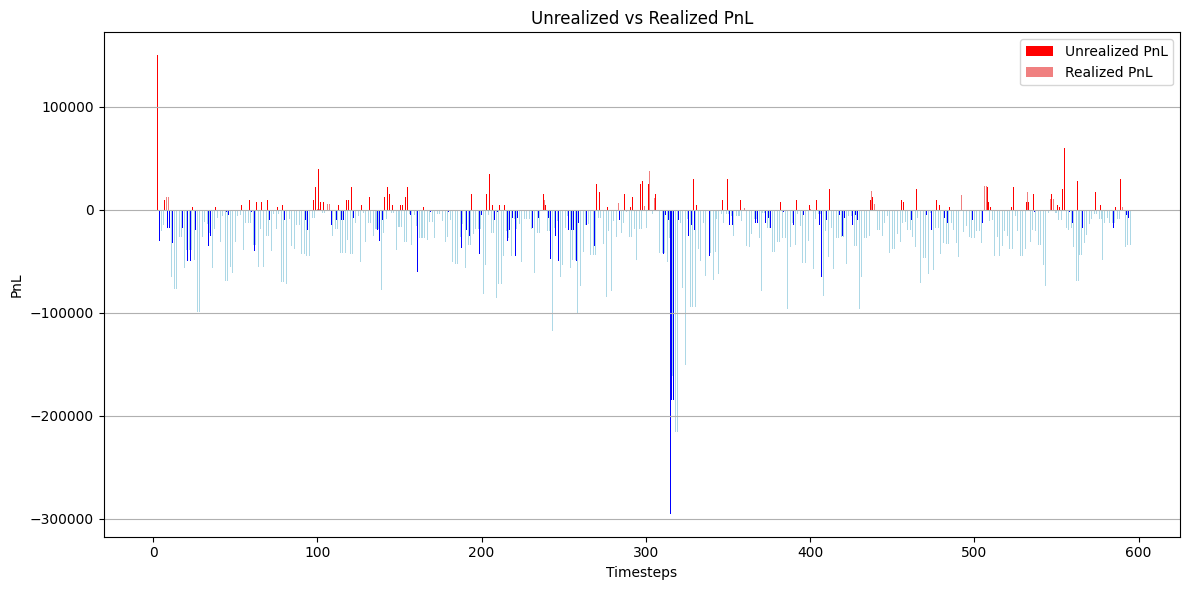

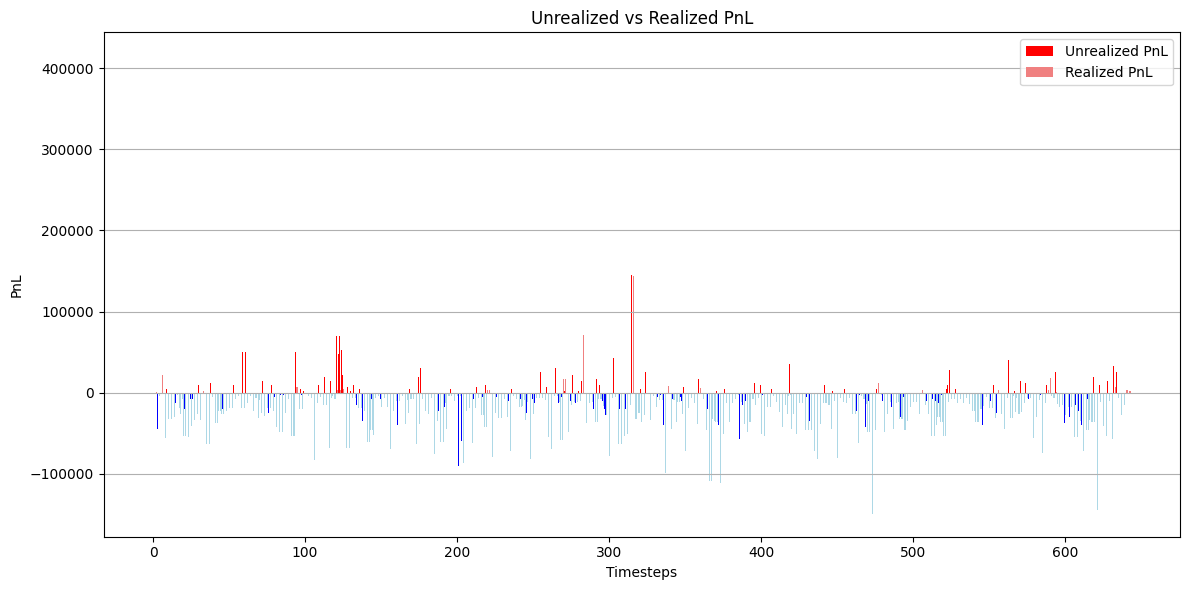

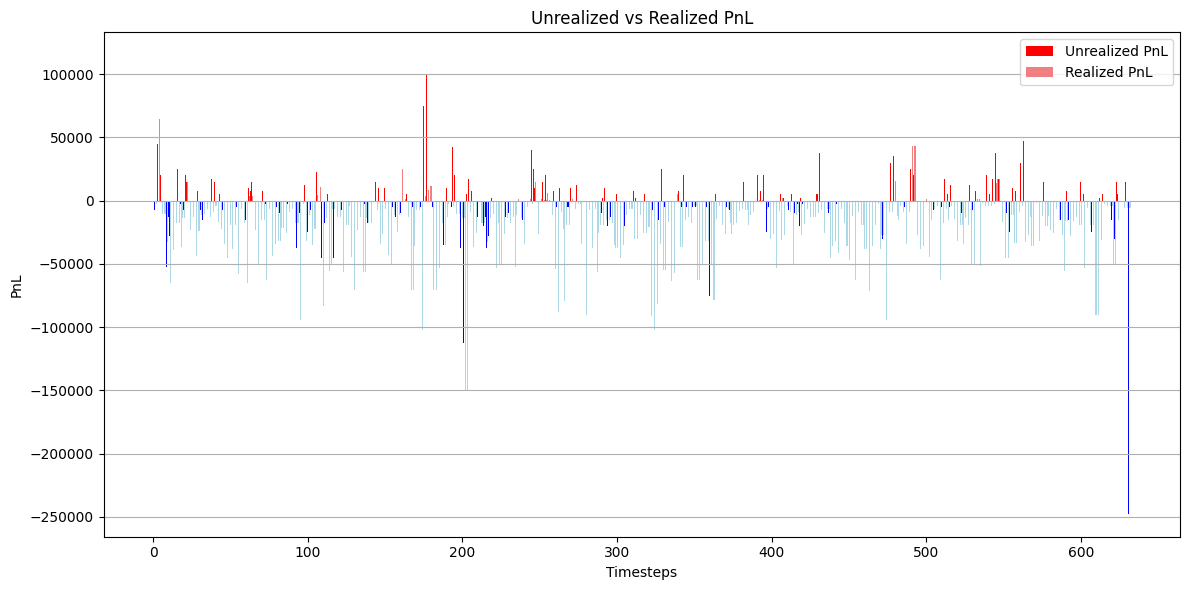

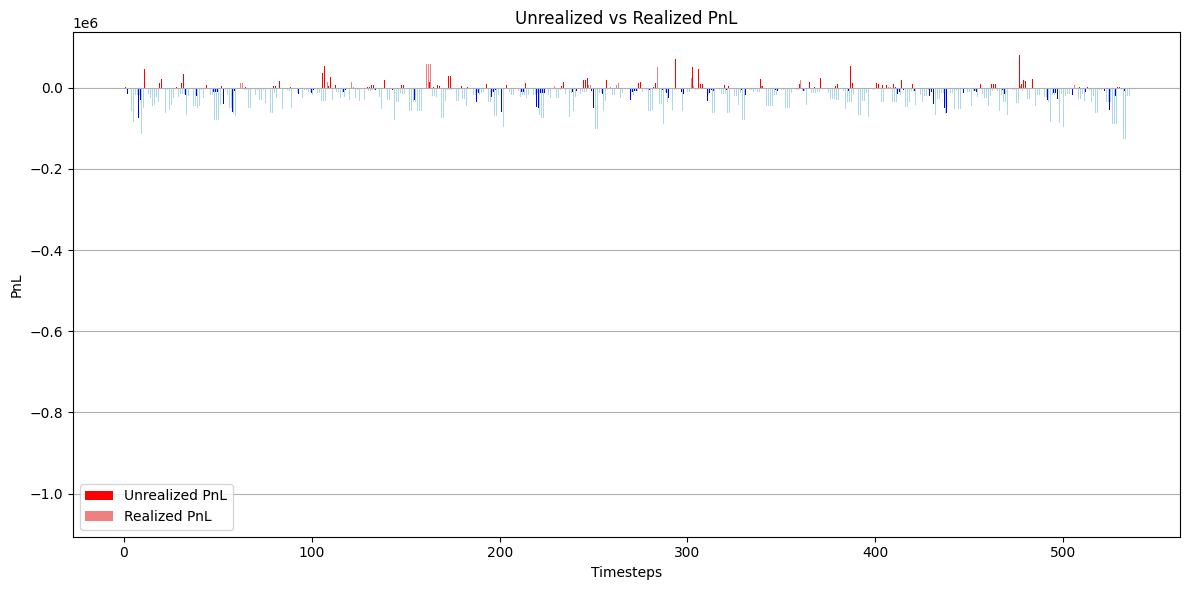

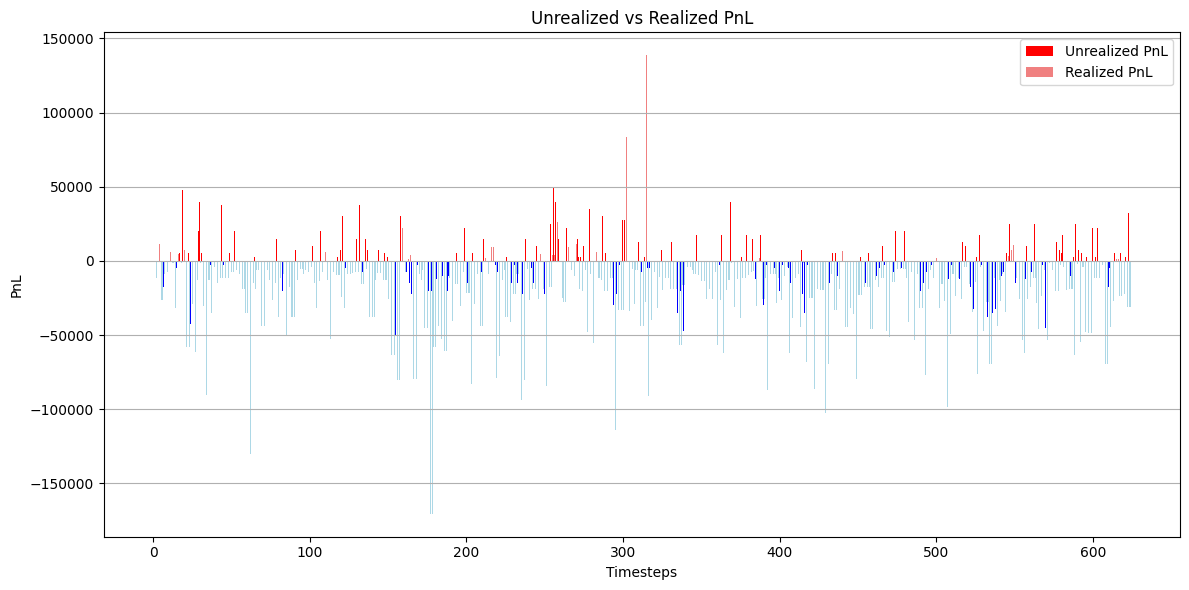

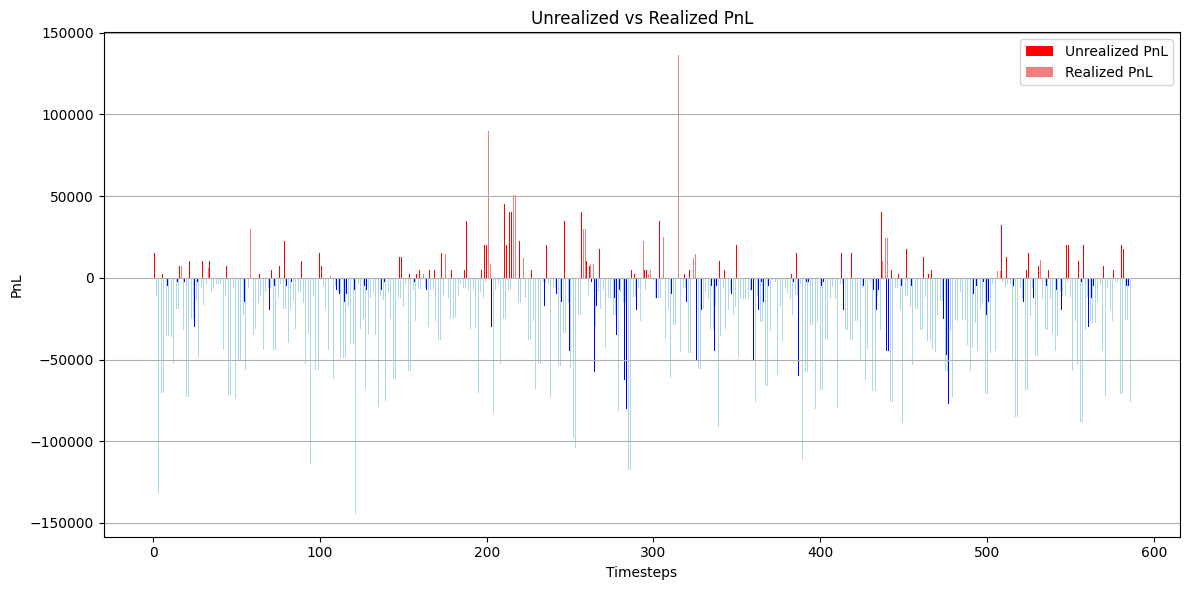

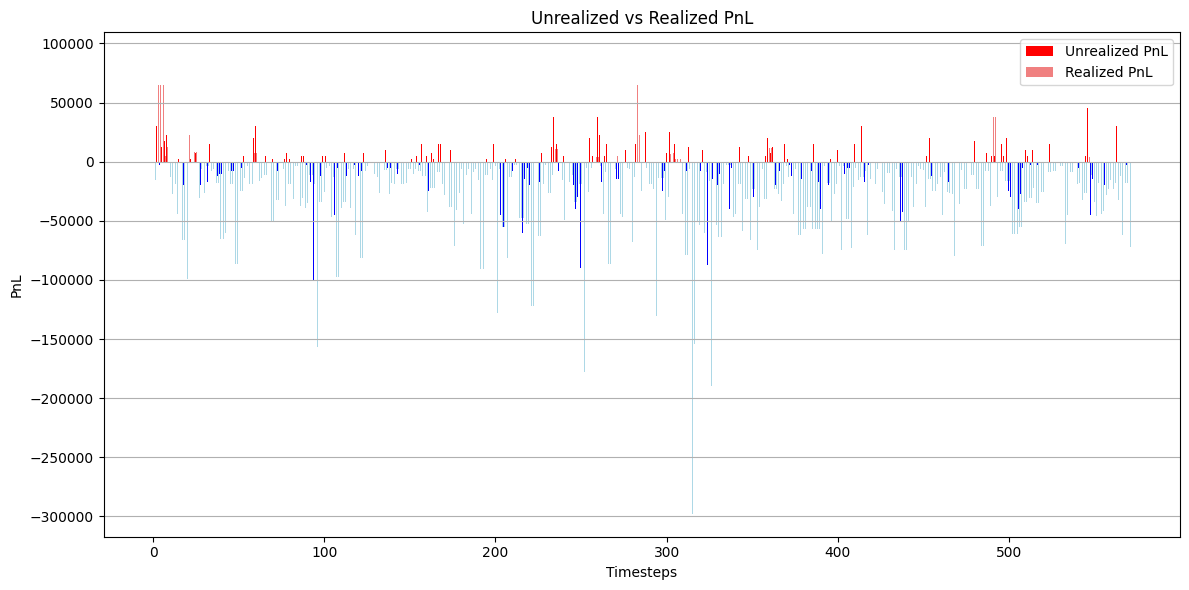

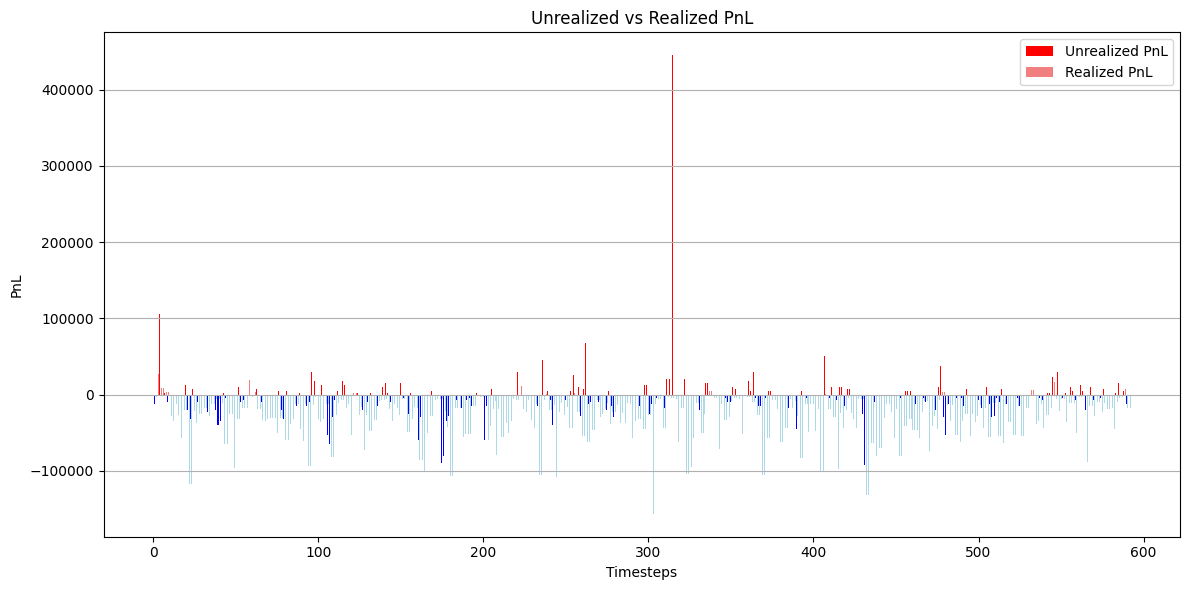

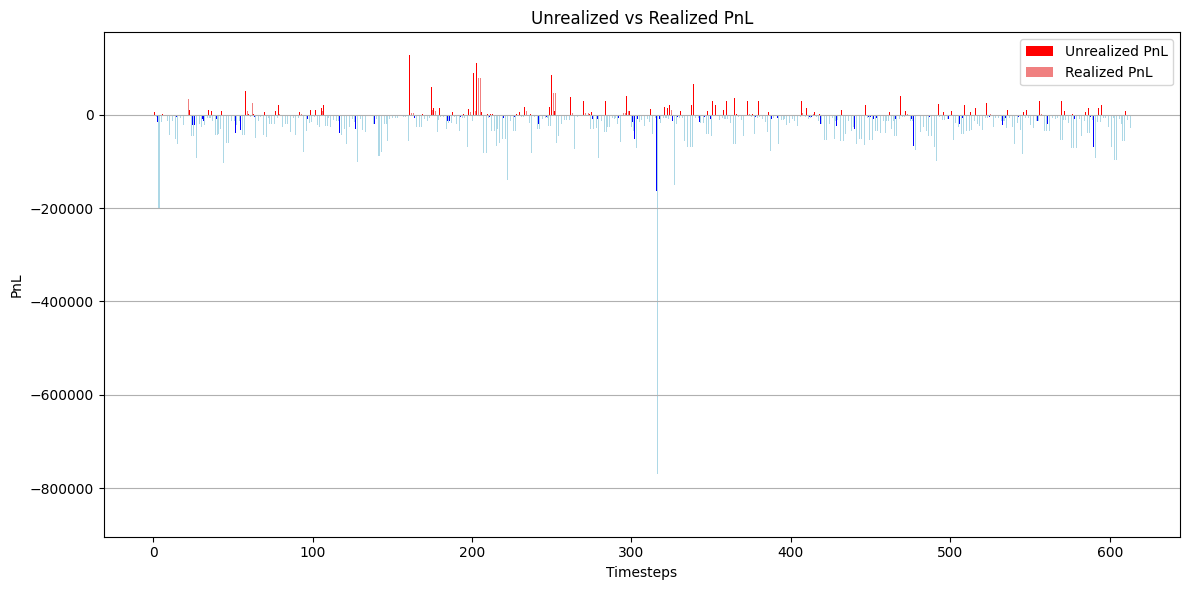

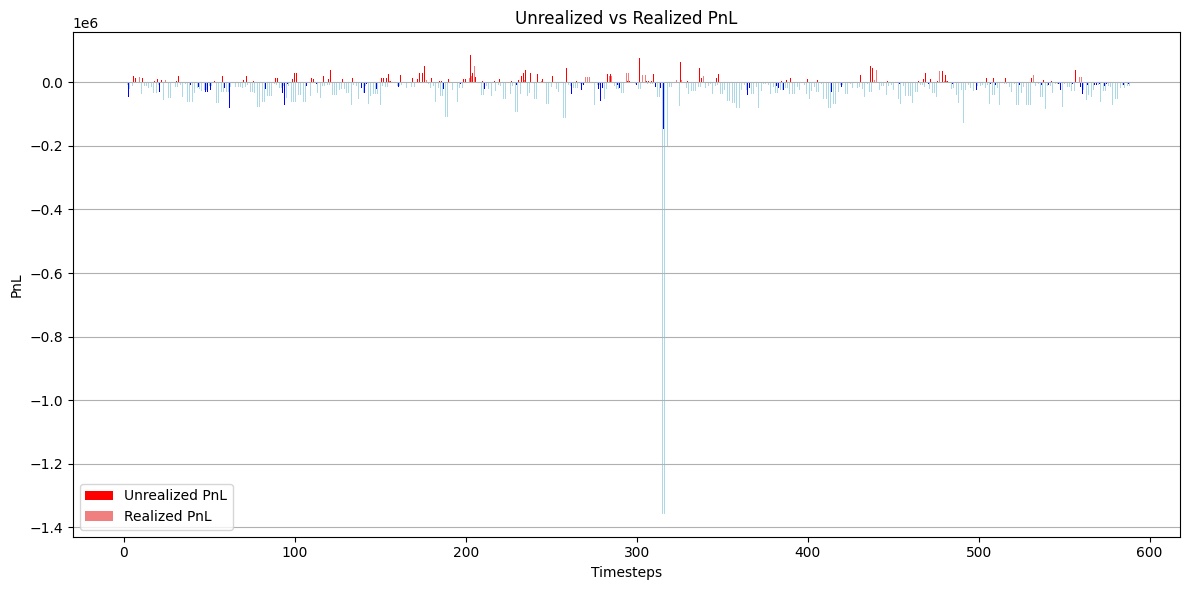

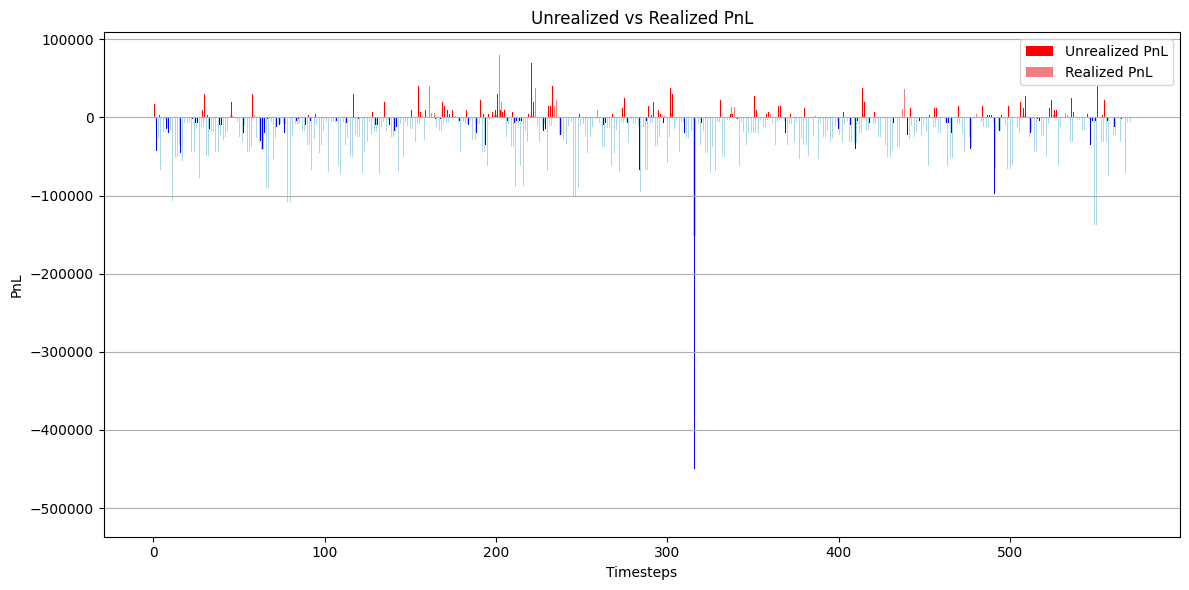

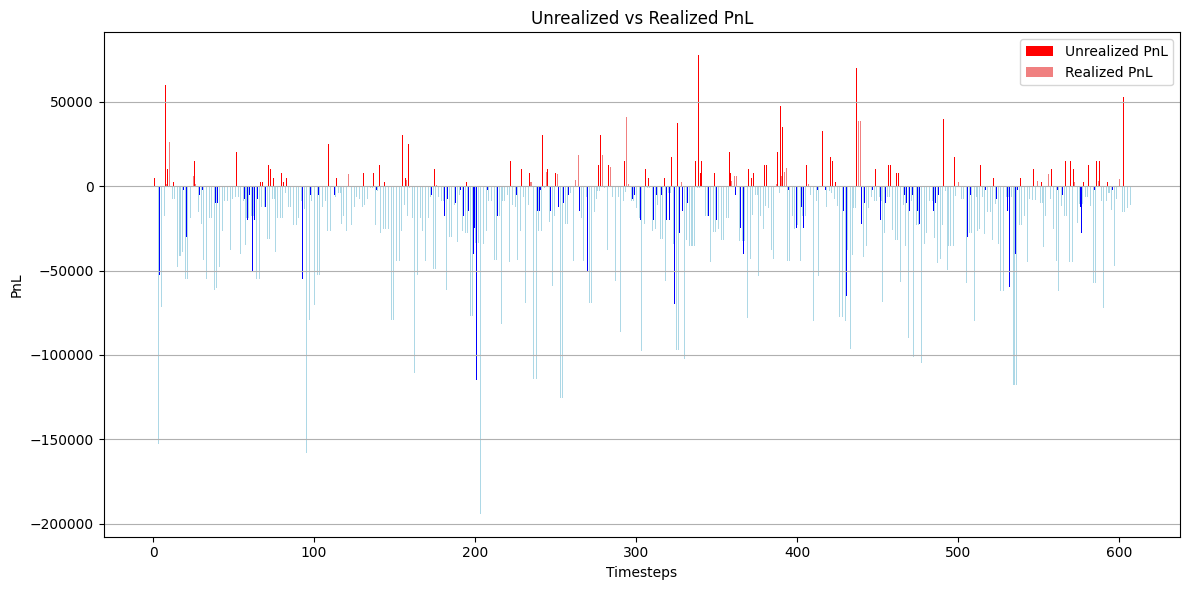

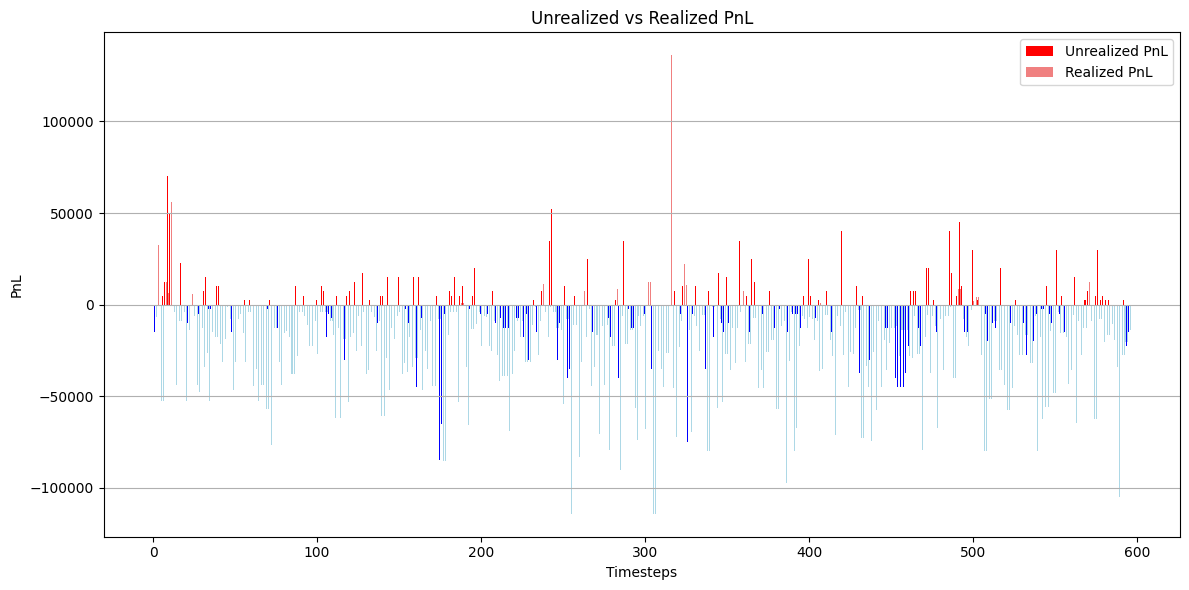

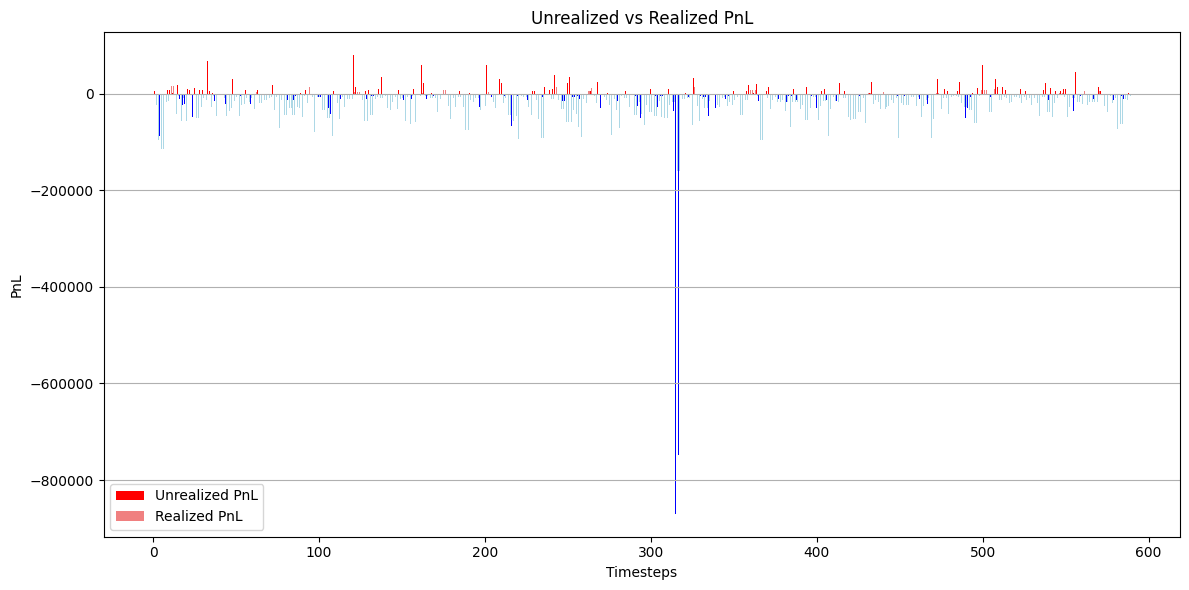

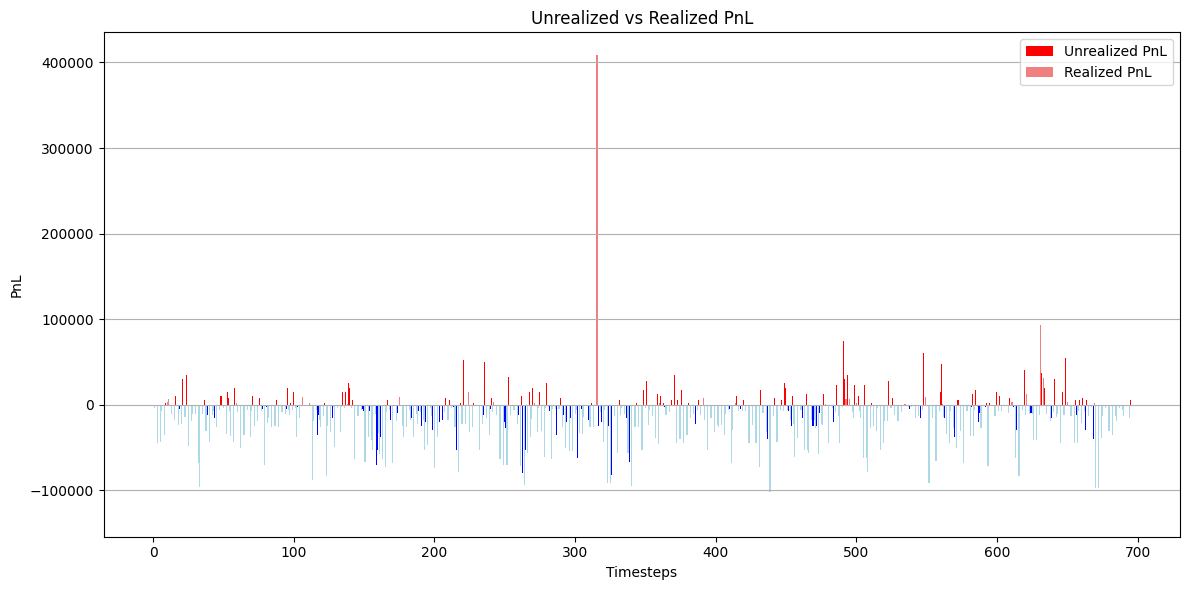

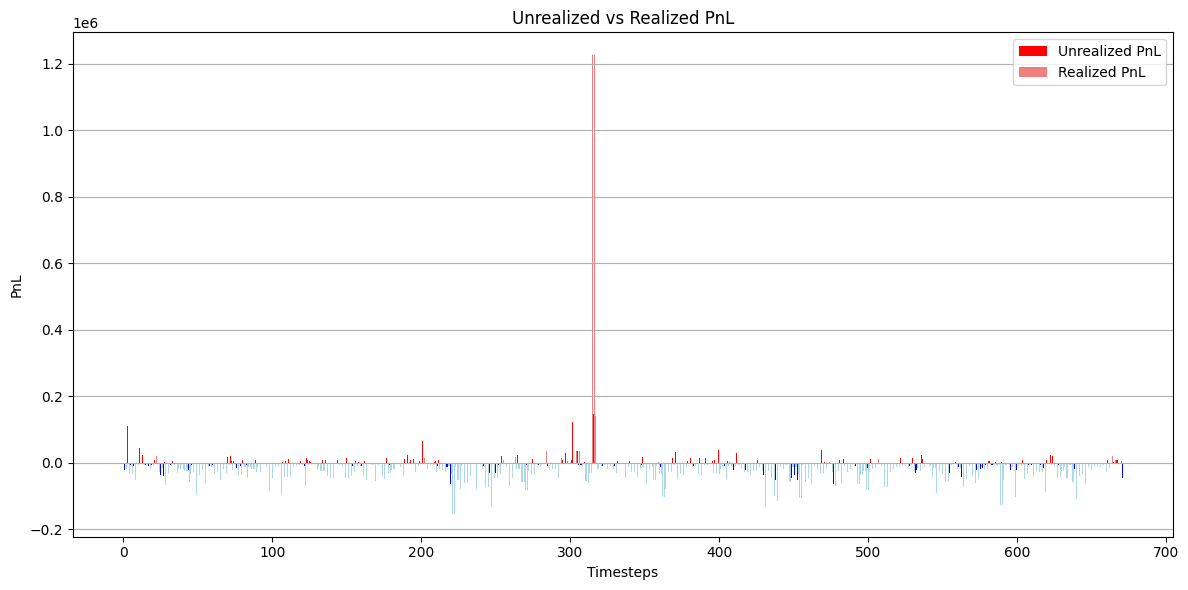

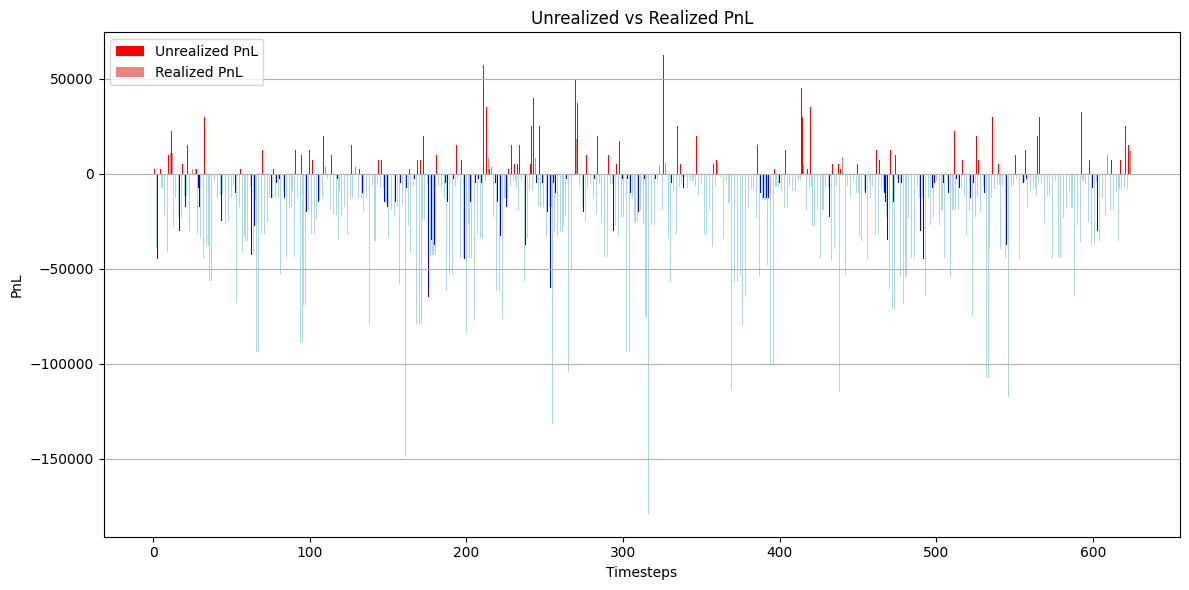

In [ ]:
trainer = EpisodicTrainer( # NonEpisodicTrainer
    df=df,
    env=FuturesEnvironment,
    train_valid_timestep=CONFIG.TRAIN_VALID_TIMESTEP,
    window_size=CONFIG.WINDOW_SIZE,
    state=state,
    reward_ftn=CONFIG.REWARD_FTN,
    done_ftn=CONFIG.DONE_FTN,
    start_budget=CONFIG.START_BUDGET,
    scaler=CONFIG.SCALER,
    position_cap=CONFIG.POSITION_CAP,
    agent=agent,
    model=model,
    optimizer=optim.Adam,
    device=CONFIG.DEVICE,
    n_steps=CONFIG.N_STEPS,
    ma_interval=CONFIG.MA_INTERVAL,
    save_interval=CONFIG.SAVE_INTERVAL,
    path=CONFIG.PATH
)

trainer.save(CONFIG)
trainer()